In [2]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, RegexpTokenizer
import torch
import numpy as np

from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay, classification_report
from tqdm import tqdm
import torch.nn as nn
from torch.optim import AdamW
from transformers import AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup, pipeline, AutoModelForTokenClassification
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import StepLR
import pickle
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler, Dataset
from torch.nn.utils.rnn import pad_sequence

c:\Users\BonNguyen\anaconda3\envs\unclekhoa\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
INPUT_PATH = "./data/danh-sach-thong-ke.xlsx"

In [5]:
def get_data(file):
    df = pd.read_excel(file, engine="openpyxl")
    return df

data = get_data(INPUT_PATH)
data.head(5)

,Nội dung xử lý,Nội dung phản ánh
0,__label__KPA,tự ý rào cột điện lấn chiếm vỉa hè. có sự cố v...
1,__label__KPA,Thưa các ban ngành đoàn thể cơ quan chức năng....
2,__label__KPA,Nhờ chính quyền long an có biện pháp giải quyế...
3,__label__KPA,XÓM TÔI CÓ 1 LỐI ĐI CHUNG 2m NHƯNG HÀNG XÓM TÔ...
4,__label__KPA,vứt rác xuống đường kênh công vụ gây cản trở n...


In [6]:
label_mapping = {"__label__KPA": 0, "__label__PA": 1}

In [7]:
data = data.rename(columns={'Nội dung xử lý': 'label'})
data = data.rename(columns={'Nội dung phản ánh': 'text'})

In [8]:
data.columns

Index(['label', 'text'], dtype='object')

In [9]:
# data.replace({"label": label_mapping}, inplace=True)

In [10]:
data.head(5)

,label,text
0,__label__KPA,tự ý rào cột điện lấn chiếm vỉa hè. có sự cố v...
1,__label__KPA,Thưa các ban ngành đoàn thể cơ quan chức năng....
2,__label__KPA,Nhờ chính quyền long an có biện pháp giải quyế...
3,__label__KPA,XÓM TÔI CÓ 1 LỐI ĐI CHUNG 2m NHƯNG HÀNG XÓM TÔ...
4,__label__KPA,vứt rác xuống đường kênh công vụ gây cản trở n...


# Data Exploration

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2411 entries, 0 to 2410
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   2411 non-null   object
 1   text    2411 non-null   object
dtypes: object(2)
memory usage: 37.8+ KB


In [12]:
data.isnull().sum()

label    0
text     0
dtype: int64

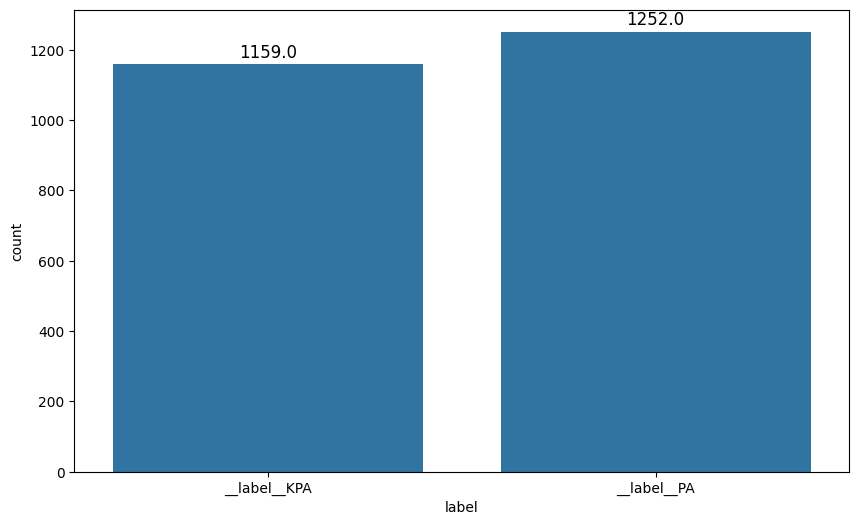

In [13]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="label", data=data)

# Add value labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Display the plot
plt.show()

In [14]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Text(0.5, 9.444444444444438, 'Token Count')

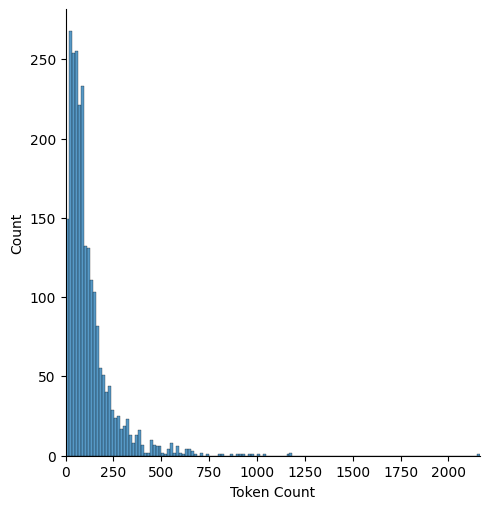

In [15]:
all_data = data['text'].tolist()
all_data = [' '.join(simple_preprocess(text)) for text in all_data]
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

# Preprocessing data

# Lower Case

In [16]:
data["text"] = data["text"].str.strip().str.replace("\n"," ")
text = data["text"]
text = [c.lower() for c in tqdm(text)]

100%|██████████| 2411/2411 [00:00<00:00, 481408.50it/s]


Đây là một ví dụ      với    khoảng trắng dư thừa.

Đây là một dòng mới.




In [17]:
text[:20]

['tự ý rào cột điện lấn chiếm vỉa hè. có sự cố và kéo dây điện không thực hiện được. cần thao tác khi không có người o nhà phải leo hàng rào. mong bên điện lực và chính quyền có hướng xử lý',
 'thưa các ban ngành đoàn thể cơ quan chức năng.nay tôi viết phản ánh này xin trình bày bức xúc chung của riêng tôi cũng như bà con lối xóm trong khu là:hiện trạng tụ tập nhiều thành phần bất hảo không rõ lí lịch nhân thân ăn nhậu.mở loa hát karaoke với công suất lớn.đậu xe.đặt bàn ghế.ngồi ăn nhậu giữa lòng đường lấn chiếm hết cả lối đi chung.gây bức xúc và ảnh hưởng rất nhiều đến cuộc sống của người dân nơi đây.nhiều lần tôi có qua nhắc nhở và đã bị họ hành hung.đe dọa.tình trạng này kéo dài hơn 5 năm nay.chính quyền địa phương vào nhắc nhở nhưng cũng không thay đổi.nay tôi kính mong chính quyền chức năng vào cuộc giúp bà con nơi đây có được không khí yên lành để an cư lạc nghiệp.tôi xin chân thành cảm ơn!!!',
 'nhờ chính quyền long an có biện pháp giải quyết vấn đề về trực tự nơi này vì đã rất 

# Replace "\n" and whitespace

In [18]:
text = [' '.join(t.strip().split()) for t in tqdm(text)]
text[:16]

  0%|          | 0/2411 [00:00<?, ?it/s]

100%|██████████| 2411/2411 [00:00<00:00, 88978.25it/s]


['tự ý rào cột điện lấn chiếm vỉa hè. có sự cố và kéo dây điện không thực hiện được. cần thao tác khi không có người o nhà phải leo hàng rào. mong bên điện lực và chính quyền có hướng xử lý',
 'thưa các ban ngành đoàn thể cơ quan chức năng.nay tôi viết phản ánh này xin trình bày bức xúc chung của riêng tôi cũng như bà con lối xóm trong khu là:hiện trạng tụ tập nhiều thành phần bất hảo không rõ lí lịch nhân thân ăn nhậu.mở loa hát karaoke với công suất lớn.đậu xe.đặt bàn ghế.ngồi ăn nhậu giữa lòng đường lấn chiếm hết cả lối đi chung.gây bức xúc và ảnh hưởng rất nhiều đến cuộc sống của người dân nơi đây.nhiều lần tôi có qua nhắc nhở và đã bị họ hành hung.đe dọa.tình trạng này kéo dài hơn 5 năm nay.chính quyền địa phương vào nhắc nhở nhưng cũng không thay đổi.nay tôi kính mong chính quyền chức năng vào cuộc giúp bà con nơi đây có được không khí yên lành để an cư lạc nghiệp.tôi xin chân thành cảm ơn!!!',
 'nhờ chính quyền long an có biện pháp giải quyết vấn đề về trực tự nơi này vì đã rất 

# Remove Punctuation

In [19]:
tokens = [word_tokenize(c) for c in tqdm(text)]
tokenizer = RegexpTokenizer(r'\w+')
tokens = [["".join(tokenizer.tokenize(word)) for word in t 
           if len(tokenizer.tokenize(word)) > 0] for t in tqdm(tokens)]
text = [" ".join(t) for t in tokens]

100%|██████████| 2411/2411 [00:00<00:00, 10506.46it/s]


In [20]:
text[:20]

['tự ý rào cột điện lấn chiếm vỉa hè có sự cố và kéo dây điện không thực hiện được cần thao tác khi không có người o nhà phải leo hàng rào mong bên điện lực và chính quyền có hướng xử lý',
 'thưa các ban ngành đoàn thể cơ quan chức năngnay tôi viết phản ánh này xin trình bày bức xúc chung của riêng tôi cũng như bà con lối xóm trong khu là hiện trạng tụ tập nhiều thành phần bất hảo không rõ lí lịch nhân thân ăn nhậumở loa hát karaoke với công suất lớnđậu xeđặt bàn ghếngồi ăn nhậu giữa lòng đường lấn chiếm hết cả lối đi chunggây bức xúc và ảnh hưởng rất nhiều đến cuộc sống của người dân nơi đâynhiều lần tôi có qua nhắc nhở và đã bị họ hành hungđe dọatình trạng này kéo dài hơn 5 năm naychính quyền địa phương vào nhắc nhở nhưng cũng không thay đổinay tôi kính mong chính quyền chức năng vào cuộc giúp bà con nơi đây có được không khí yên lành để an cư lạc nghiệptôi xin chân thành cảm ơn',
 'nhờ chính quyền long an có biện pháp giải quyết vấn đề về trực tự nơi này vì đã rất nhiều lần nơi này 

In [21]:
data['text'] = text

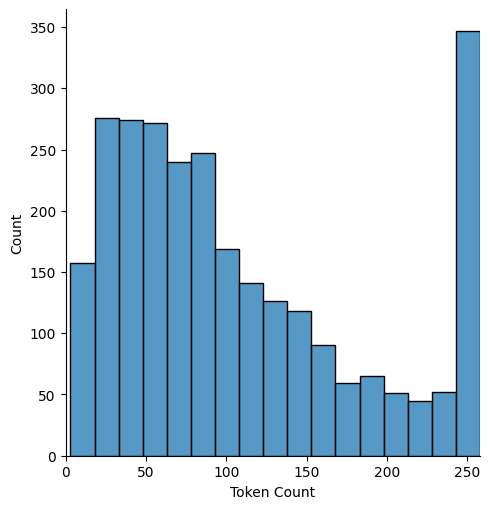

In [22]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

all_data = data['text']
all_data = [' '.join(simple_preprocess(text)) for text in all_data]

def split_text_into_chunks(text, tokenizer, max_length=256):
    encoded_text = tokenizer.encode(text, add_special_tokens=False)
    chunks = [encoded_text[i:i+max_length] for i in range(0, len(encoded_text), max_length)]
    return [tokenizer.build_inputs_with_special_tokens(chunk) for chunk in chunks]

# Apply the splitting function
encoded_chunks = [split_text_into_chunks(text, tokenizer) for text in all_data]
encoded_chunks_flat = [item for sublist in encoded_chunks for item in sublist]
token_lens = [len(chunk) for chunk in encoded_chunks_flat]

# Plot the token lengths
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.show()

In [23]:
data.head(5)

,label,text
0,__label__KPA,tự ý rào cột điện lấn chiếm vỉa hè có sự cố và...
1,__label__KPA,thưa các ban ngành đoàn thể cơ quan chức năngn...
2,__label__KPA,nhờ chính quyền long an có biện pháp giải quyế...
3,__label__KPA,xóm tôi có 1 lối đi chung 2m nhưng hàng xóm tô...
4,__label__KPA,vứt rác xuống đường kênh công vụ gây cản trở n...


# Remove Stopword

In [3]:
from stopwordsiso import stopwords

vietnamese_stopwords = stopwords(['vi'])

In [5]:
len(vietnamese_stopwords)

645

In [24]:
def remove_stopwords(sentence, stopwords):
    tokens = sentence.split()
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords]
    return ' '.join(filtered_tokens)

data['text_cleaned'] = data['text'].apply(lambda x: remove_stopwords(x, vietnamese_stopwords))

In [25]:
data.columns

Index(['label', 'text', 'text_cleaned'], dtype='object')

In [26]:
data.shape

(2411, 3)

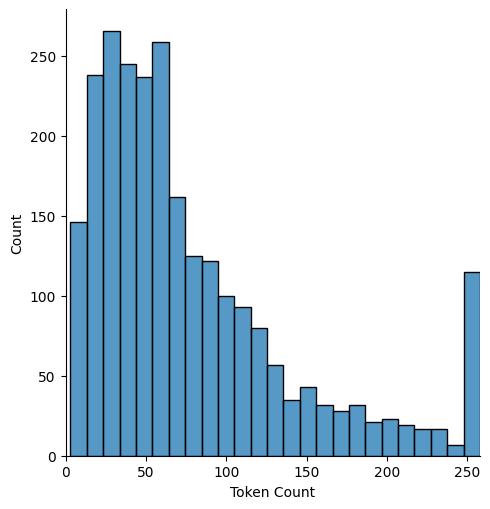

In [27]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

all_data = data['text_cleaned']
all_data = [' '.join(simple_preprocess(text)) for text in all_data]

def split_text_into_chunks(text, tokenizer, max_length=256):
    encoded_text = tokenizer.encode(text, add_special_tokens=False)
    chunks = [encoded_text[i:i+max_length] for i in range(0, len(encoded_text), max_length)]
    return [tokenizer.build_inputs_with_special_tokens(chunk) for chunk in chunks]

# Apply the splitting function
encoded_chunks = [split_text_into_chunks(text, tokenizer) for text in all_data]
encoded_chunks_flat = [item for sublist in encoded_chunks for item in sublist]
token_lens = [len(chunk) for chunk in encoded_chunks_flat]

# Plot the token lengths
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.show()

In [28]:
data.drop(columns="text", axis=1, inplace=True)

In [29]:
data.columns

Index(['label', 'text_cleaned'], dtype='object')

In [30]:
data.rename(columns={'text_cleaned':'text'}, inplace=True)

In [31]:
data.head(5)

,label,text
0,__label__KPA,tự rào cột điện lấn chiếm vỉa hè cố kéo dây đi...
1,__label__KPA,thưa ban ngành đoàn thể quan chức năngnay viết...
2,__label__KPA,nhờ quyền long an biện pháp giải vấn đề trực t...
3,__label__KPA,xóm 1 lối chung 2m hàng xóm nhậu nhẹt chiếm lố...
4,__label__KPA,vứt rác đường kênh công vụ gây cản trở dân lưu...


# Word Segmentation

In [32]:
# Load the tokenizer and model
tokenizer_ = AutoTokenizer.from_pretrained("./Word_Segmentation/NlpHUST/vi-word-segmentation")
model_ = AutoModelForTokenClassification.from_pretrained("./Word_Segmentation/NlpHUST/vi-word-segmentation")

# Define the NLP pipeline
nlp = pipeline("token-classification", model=model_, tokenizer=tokenizer_)

def segment_text_with_nlp(text, max_length=512):
    # Tokenize the text and split into chunks
    tokens = tokenizer_(text, return_tensors="pt", truncation=False, padding=False)
    input_ids = tokens['input_ids'].squeeze().tolist()

    # Split input_ids into manageable chunks
    chunk_size = max_length - 2  # Reserve space for [CLS] and [SEP]
    chunks = [input_ids[i:i + chunk_size] for i in range(0, len(input_ids), chunk_size)]
    
    words = []
    for chunk in chunks:
        # Add special tokens to each chunk
        chunk_with_special_tokens = [tokenizer_.cls_token_id] + chunk + [tokenizer_.sep_token_id]
        chunk_text = tokenizer_.decode(chunk_with_special_tokens, skip_special_tokens=True)
        
        # Process the chunk using the pipeline
        ner_results = nlp(chunk_text)
        
        for e in ner_results:
            if e["word"].startswith("##"):
                words[-1] += e["word"].replace("##", "")
            elif e["entity"] == "I":
                words[-1] += "_" + e["word"]
            else:
                words.append(e["word"])
    
    return ' '.join(words)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [33]:
# data_ = {
#     "text": [
#         "Đây là một ví dụ về phân đoạn từ tiếng Việt.",
#         "Chào mừng bạn đến với thế giới của NLP.",
#         "Phát biểu tại phiên thảo luận về tình hình kinh tế xã hội của Quốc hội sáng 28/10 , Bộ trưởng Bộ LĐ-TB&XH Đào Ngọc Dung khái quát , tại phiên khai mạc kỳ họp , lãnh đạo chính phủ đã báo cáo , đề cập tương đối rõ ràng về việc thực hiện các chính sách an sinh xã hội" * 10  # Simulate a long text
#     ]
# }

# df = pd.DataFrame(data_)

# df["segmented_text"] = df["text"].apply(segment_text_with_nlp)

# # Display the result
# print(df)

In [34]:
data["segmented_text"] = data["text"].apply(segment_text_with_nlp)
data.shape

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


(2411, 3)

In [35]:
data.head(5)

,label,text,segmented_text
0,__label__KPA,tự rào cột điện lấn chiếm vỉa hè cố kéo dây đi...,tự rào cột điện lấn_chiếm vỉa_hè cố kéo dây_đi...
1,__label__KPA,thưa ban ngành đoàn thể quan chức năngnay viết...,thưa ban_ngành đoàn_thể quan_chức_năngnay viết...
2,__label__KPA,nhờ quyền long an biện pháp giải vấn đề trực t...,nhờ quyền long_an biện_pháp giải vấn_đề trực t...
3,__label__KPA,xóm 1 lối chung 2m hàng xóm nhậu nhẹt chiếm lố...,xóm 1 lối chung 2m hàng_xóm nhậu_nhẹt chiếm lố...
4,__label__KPA,vứt rác đường kênh công vụ gây cản trở dân lưu...,vứt rác đường kênh công_vụ gây cản_trở dân lưu...


In [36]:
data.drop(columns="text", axis=1, inplace=True)

In [37]:
data.rename(columns={'segmented_text':'text'}, inplace=True)

In [38]:
data.columns

Index(['label', 'text'], dtype='object')

In [39]:
data.shape

(2411, 2)

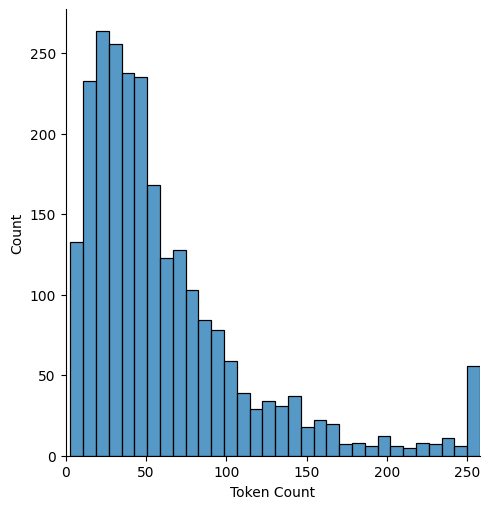

In [40]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

all_data = data['text']
all_data = [' '.join(simple_preprocess(text)) for text in all_data]

def split_text_into_chunks(text, tokenizer, max_length=256):
    encoded_text = tokenizer.encode(text, add_special_tokens=False)
    chunks = [encoded_text[i:i+max_length] for i in range(0, len(encoded_text), max_length)]
    return [tokenizer.build_inputs_with_special_tokens(chunk) for chunk in chunks]

# Apply the splitting function
encoded_chunks = [split_text_into_chunks(text, tokenizer) for text in all_data]
encoded_chunks_flat = [item for sublist in encoded_chunks for item in sublist]
token_lens = [len(chunk) for chunk in encoded_chunks_flat]

# Plot the token lengths
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.show()

# Save Prep-data

In [41]:
# data.to_excel("./data/data.xlsx")

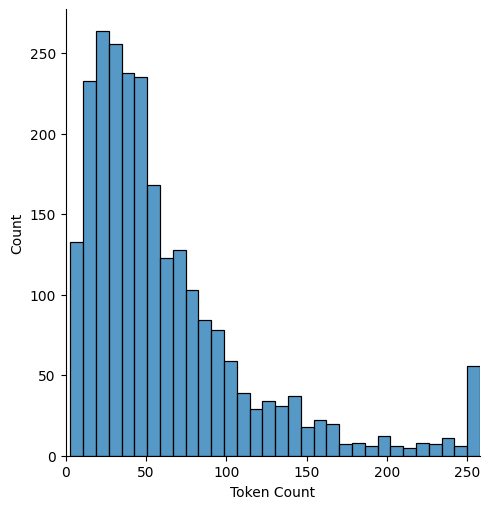

In [42]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)
all_data = data['text']
all_data = [' '.join(simple_preprocess(text)) for text in all_data]

# Apply the splitting function
encoded_chunks = [split_text_into_chunks(text, tokenizer) for text in all_data]
encoded_chunks_flat = [item for sublist in encoded_chunks for item in sublist]
token_lens = [len(chunk) for chunk in encoded_chunks_flat]

# Plot the token lengths
sns.displot(token_lens)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.show()

# Training - Using colab for training

# Custom dataset

In [43]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def labelencoder(self, text):
        if text == '__label__KPA':
            return 0
        else:
            return 1

    def get_input_data(self, row):
        text = row['text']
        text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['label'])
        return text, label

In [44]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

# Check tokenizer's vocabulary size
print(f'Tokenizer vocabulary size: {tokenizer.vocab_size}')

Tokenizer vocabulary size: 64000


In [45]:
vocab_size = tokenizer.vocab_size

def adjust_input_ids(input_ids, vocab_size):
    return torch.where(input_ids < vocab_size, input_ids, torch.tensor(vocab_size-1).to(input_ids.device))

def train(model, criterion, optimizer, train_loader, lr_scheduler):
    model.train()
    losses = []
    correct = 0

    for data in tqdm(train_loader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        # Adjust input_ids
        input_ids = adjust_input_ids(input_ids, vocab_size)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs

        loss = criterion(logits, targets)

        _, pred = torch.max(logits, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

    lr_scheduler.step()

    epoch_loss = np.mean(losses)
    epoch_acc = correct.double() / len(train_loader.dataset)

    print(f'Train Accuracy: {epoch_acc} Loss: {epoch_loss}')
    return epoch_loss, epoch_acc

def evaluate(model, criterion, valid_loader):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        for data in tqdm(valid_loader, desc="Validation"):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            # Adjust input_ids
            input_ids = adjust_input_ids(input_ids, vocab_size)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs

            loss = criterion(logits, targets)
            _, pred = torch.max(logits, dim=1)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    epoch_loss = np.mean(losses)
    epoch_acc = correct.double() / len(valid_loader.dataset)

    print(f'Validation Accuracy: {epoch_acc} Loss: {epoch_loss}')
    return epoch_loss, epoch_acc

In [46]:
class TextClassifier(nn.Module):
    def __init__(self, n_classes=2):
        super(TextClassifier, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=n_classes)
        self.drop = nn.Dropout(p=0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        x = self.drop(logits)
        return x

In [47]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, fold):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title(f'Training and Validation Loss (Fold {fold})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (Fold {fold})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


def kfold_cross_validation(df, k, device, EPOCHS, batch_size, max_len):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['label'])):
        print(f'Fold {fold+1}/{k}')

        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]

        train_dataset = TextDataset(train_df, tokenizer, max_len)
        val_dataset = TextDataset(val_df, tokenizer, max_len)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = TextClassifier(n_classes=2)
        model.to(device)

        optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
        criterion = nn.CrossEntropyLoss()
        lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader) * EPOCHS
        )

        best_acc = 0
        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []

        for epoch in range(EPOCHS):
            print(f'Epoch {epoch+1}/{EPOCHS}')
            print('-'*30)

            train_loss, train_acc = train(model, criterion, optimizer, train_loader, lr_scheduler)
            val_loss, val_acc = evaluate(model, criterion, val_loader)

            train_losses.append(train_loss)
            train_accuracies.append(train_acc.item())
            val_losses.append(val_loss)
            val_accuracies.append(val_acc.item())

            if val_acc > best_acc:
                torch.save(model.state_dict(), f'/content/drive/MyDrive/Saved_Model/{fold+1}.pth')
                best_acc = val_acc

        fold_results.append({
            'fold': fold + 1,
            'train_losses': train_losses,
            'train_accuracies': train_accuracies,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'best_acc': best_acc
        })

        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, fold+1)

    return fold_results

# Training

In [48]:
# EPOCHS = 10
# batch_size = 32
# max_len = 256

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# train_, test_data = train_test_split(data, test_size=0.2, random_state=42)
# train_data, val_data = train_test_split(train_, test_size=0.2, random_state=42)

# train_dataset = TextDataset(train_data, tokenizer, max_len)
# valid_dataset = TextDataset(val_data, tokenizer, max_len)
# test_dataset = TextDataset(test_data, tokenizer, max_len)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# # Perform k-fold cross-validation
# k = 5  # Number of folds
# results = kfold_cross_validation(data, k, device, EPOCHS, batch_size, max_len)

# # Print results
# for fold_result in results:
#     print(f"Fold {fold_result['fold']}:")
#     print(f"  Best Validation Accuracy: {fold_result['best_acc']:.4f}")
#     print(f"  Training Losses: {fold_result['train_losses']}")
#     print(f"  Training Accuracies: {fold_result['train_accuracies']}")
#     print(f"  Validation Losses: {fold_result['val_losses']}")
#     print(f"  Validation Accuracies: {fold_result['val_accuracies']}")
#     print()